In [1]:
import numpy as np
import operator
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import csv

import random
import folium
from folium.plugins import MarkerCluster
import pandas_profiling
import missingno as msno
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.distance import great_circle
import json
import vincent
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values and vice versa
from selenium import webdriver
import time

%matplotlib inline
vincent.core.initialize_notebook()

# Introduction
The aim of the project was to learn how work on production type datasets and to learn how CRISP-DM is applied in production settings. To this end, I will be looking into the time and geographical variations in the followings:
<ul>
<li>The variation in the number of respondents over the period under study</li>
<li>The variation in the gender distribution over the period</li>
<li>The variation in the job satisfaction metrics over the period</li>
<li>The variation in the top three programming languages over the period</li>
</ul>

References:
https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10

https://www.kaggle.com/dabaker/fancy-folium

https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/

https://insights.stackoverflow.com/survey

https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook

In [2]:
current_wd = os.getcwd()

# Utility to manage raw data from csv files
The raw data used here consists of csv files for the period 2017 to 2020. The notebook can be modified to take more data from the annual surveys:
__[Link to annual surveys](https://insights.stackoverflow.com/survey)__

In [3]:
class RawDataManager:
    """
    Used to manage raw data from and csv files

    ...

    Attributes
    ----------
    __columns : str
        columns in the csv file and dataframe
    __root_dir : str
        name of the directory containing the sub directories for data files
    __survey_results_files_dict : dictionary
        dictionary of csv file names in the data directories
    years_under_analysis : list
        list of years representing the names of data directories  
    df_concat : pandas dataframe
        dataframe data from the csv files
    Methods
    -------
    read_csv_files:
        reads data from csv files into a pandas dataframe
    get_df_for_selected_years:
        returns a slice of df_concat based on a list of years
    """
    
    def __init__(self):
        """
        Constructs and iniializes all attributes of RawDataManager.

        Parameters
        ----------
            None
        """
    
        self.__root_dir = current_wd + '/stack-overflow-raw-data-files-1/'
        self.__columns = ['Country', 'DevType', 'DatabaseDesireNextYear',
                          'DatabaseWorkedWith', 'EdLevel', 'Employment', 'Gender',
                          'JobSat', 'JobSeek',
                          'LanguageDesireNextYear', 'LanguageWorkedWith', 'OrgSize',
                          'SOComm', 'UndergradMajor']

        self.__survey_results_files_dict = {'2017':'survey_results_public_aligned.csv',
                                          '2018':'survey_results_public_aligned.csv',
                                          '2019':'survey_results_public.csv',
                                          '2020':'survey_results_public.csv'}
            
        self.years_under_analysis = self.__survey_results_files_dict.keys()

        self.df_concat = None

    def read_csv_files(self, file_names_list=None):
        """
        Reads a list of csv files into a pandas dataframe
        
        Parameters
        ----------
            file_names_list : list
                list of csv file names, defaults to internal list if no list is provided
        
        Returns
        -------
        a dictionary of dataframes
        """
        missing_values_type_list = ["--", "", " ", "?", "None", "-", "NONE",
                                    "none", "inf", "INF", "-999","Inf"]
        if file_names_list == None:
            file_names_list = self.__survey_results_files_dict.keys()
            
        df_store_dict_loc = dict()
        
        for key in file_names_list: #self.__survey_results_files_dict.keys():
            survey_file_path = self.__root_dir + key + '/' + self.__survey_results_files_dict[key]
            df = pd.read_csv(survey_file_path, skipinitialspace=True,
                             usecols=self.__columns, low_memory=False, 
                             na_values=missing_values_type_list)

            df['Year'] = key
            df_store_dict_loc[key] = df
        return df_store_dict_loc

    def set_job_satisfaction_index(self, df_store_dict):
        """
        sets the scores for job satisfaction using numerical scale
        
        Parameters
        ----------
             df_store_dict : dict()
                dictionary of dataframes
        
        Returns
        -------
        dictionary of modified dataframes
        """
        df_store_dict_loc = dict()
        for year in df_store_dict.keys():
            df = df_store_dict[year]
            if year == '2017':
                df_store_dict_loc[year] = df
            elif year == '2018':
                df.replace(to_replace = 'Extremely dissatisfied', value=1, inplace=True)
                df.replace(to_replace = 'Moderately dissatisfied', value=2, inplace=True)
                df.replace(to_replace = 'Slightly dissatisfied', value=3, inplace=True)
                df.replace(to_replace = 'Neither satisfied nor dissatisfied', value=4, inplace=True)
                df.replace(to_replace = 'Slightly satisfied', value=5, inplace=True)
                df.replace(to_replace = 'Moderately satisfied', value=6, inplace=True)
                df.replace(to_replace = 'Extremely satisfied', value=7, inplace=True)
                df_store_dict_loc[year] = df
            elif year == '2019' or year == '2020':
                df.replace(to_replace = 'Very dissatisfied', value=1, inplace=True)
                df.replace(to_replace = 'Slightly dissatisfied', value=2, inplace=True)
                df.replace(to_replace = 'Neither satisfied nor dissatisfied', value=3, inplace=True)
                df.replace(to_replace = 'Slightly satisfied', value=4, inplace=True)
                df.replace(to_replace = 'Very satisfied', value=5, inplace=True)
                df_store_dict_loc[year] = df
        return df_store_dict_loc

    def join_data_frames(self, df_store_dict):
        """
        joins dataframes by concat operations to yield a single dataframe
        
        Parameters
        ----------
             df_store_dict : dict()
                dictionary of dataframes
        
        Returns
        -------
        None
        """
        self.df_concat = pd.concat(df_store_dict, keys=df_store_dict.keys())
        
    def get_df_for_selected_years(self, selected_years_list=None):
        """
        returns a slice of df_concat based on the input.

        Parameters
        ----------
            selected_years_list : list
                list of years for slicing
                
        Returns
        -------
        dataframe
        """
        if year in selected_years_list == None:
            return df_concat
        
        df_store_dict_loc = dict()
        for year in selected_years_list:
            if len(selected_years_list) == 1:
                return self.df_concat.loc[year]
            else:
                df_store_dict_loc[year] = self.df_concat.loc[year]
        return pd.concat(df_store_dict_loc, \
                         keys=df_store_dict_loc.keys()) 
    
    def analyze_missing_values(self, df):
        """
        Performs analysis of missing values in a pandas dataframe
        
        Parameters
        ----------
             df : dataframe
                pandas dataframe of values
        
        Returns
        -------
        None
        """
        df_null_count = df.isnull().sum()
        df_null_count_percent = 100.0 * df_null_count / len(df)
        df_null_count_percent.plot.bar(x=df_null_count_percent.index, y=df_null_count_percent.values)
        plt.ylabel('Percentage number of missing values')
        plt.xlabel('Column')
        plt.show()
    
    def missing_values_correlation(self, df):
        """
        plots the correlation heat map of missing values for a pandas dataframe
        
        Parameters
        ----------
             df : dataframe 
                pandas dataframe of values
        
        Returns
        -------
        dictionary of modified dataframes
        """
        msno.heatmap(df)
        plt.show()

# The Raw Data and its properties 

In [4]:
rawDataManager = RawDataManager()

In [5]:
years_df_dict = rawDataManager.read_csv_files()

## Initial look at the yearly raw data

In [6]:
for year in years_df_dict.keys():
    print('Year: ', year)
    df = years_df_dict[year]
    display(df.head())

Year:  2017


,Country,Employment,EdLevel,UndergradMajor,OrgSize,DevType,JobSat,JobSeek,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,SOComm,Gender,Year
0,United States,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,NaN,"I'm not actively looking, but I am open to new...",Swift,Swift,NaN,NaN,Strongly agree,Male,2017
1,United Kingdom,Employed part-time,Some college/university study without earning ...,Computer science or software engineering,20 to 99 employees,NaN,NaN,NaN,JavaScript; Python; Ruby; SQL,Java; Python; Ruby; SQL,MySQL; SQLite,MySQL; SQLite,Strongly agree,Male,2017
2,United Kingdom,Employed full-time,Bachelor's degree,Computer science or software engineering,"10,000 or more employees",Other,9.0,NaN,Java; PHP; Python,C; Python; Rust,MySQL,NaN,Strongly agree,Male,2017
3,United States,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"10,000 or more employees",NaN,3.0,I am actively looking for a job,Matlab; Python; R; SQL,Matlab; Python; R; SQL,MongoDB; Redis; SQL Server; MySQL; SQLite,MongoDB; Redis; SQL Server; MySQL; SQLite,Strongly agree,Male,2017
4,Switzerland,Employed full-time,Master's degree,Computer science or software engineering,10 to 19 employees,Mobile developer; Graphics programming; Deskto...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017


Year:  2018


,Country,Employment,EdLevel,UndergradMajor,OrgSize,DevType,JobSat,JobSeek,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,SOComm,Gender,Year
0,Kenya,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,Extremely satisfied,"I’m not actively looking, but I am open to new...",JavaScript;Python;HTML;CSS,JavaScript;Python;HTML;CSS,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Redis;SQL Server;MySQL;PostgreSQL;Amazon RDS/A...,Yes,Male,2018
1,United Kingdom,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,Moderately dissatisfied,I am actively looking for a job,JavaScript;Python;Bash/Shell,Go;Python,Redis;PostgreSQL;Memcached,PostgreSQL,Yes,Male,2018
2,United States,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,Moderately satisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,NaN,NaN,NaN,NaN,2018
3,United States,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,Neither satisfied nor dissatisfied,"I’m not actively looking, but I am open to new...",C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,"SQL Server;Microsoft Azure (Tables, CosmosDB, ...","SQL Server;Microsoft Azure (Tables, CosmosDB, ...",Yes,Male,2018
4,South Africa,Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,Slightly satisfied,"I’m not actively looking, but I am open to new...",C;C++;Java;Matlab;R;SQL;Bash/Shell,Assembly;C;C++;Matlab;SQL;Bash/Shell,SQL Server;PostgreSQL;Oracle;IBM Db2,PostgreSQL;Oracle;IBM Db2,Yes,Male,2018


Year:  2019


,Employment,Country,EdLevel,UndergradMajor,OrgSize,DevType,JobSat,JobSeek,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,SOComm,Gender,Year
0,"Not employed, and not looking for work",United Kingdom,Primary/elementary school,NaN,NaN,NaN,NaN,NaN,HTML/CSS;Java;JavaScript;Python,C;C++;C#;Go;HTML/CSS;Java;JavaScript;Python;SQL,SQLite,MySQL,Neutral,Man,2019
1,"Not employed, but looking for work",Bosnia and Herzegovina,"Secondary school (e.g. American high school, G...",NaN,NaN,"Developer, desktop or enterprise applications;...",NaN,I am actively looking for a job,C++;HTML/CSS;Python,C++;HTML/CSS;JavaScript;SQL,NaN,MySQL,"Yes, somewhat",Man,2019
2,Employed full-time,Thailand,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",Slightly satisfied,"I’m not actively looking, but I am open to new...",HTML/CSS,Elixir;HTML/CSS,PostgreSQL,PostgreSQL,Neutral,Man,2019
3,Employed full-time,United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,"Developer, full-stack",Slightly satisfied,I am not interested in new job opportunities,C;C++;C#;Python;SQL,C;C#;JavaScript;SQL,MySQL;SQLite,MySQL;SQLite,"No, not really",Man,2019
4,Employed full-time,Ukraine,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...","10,000 or more employees","Academic researcher;Developer, desktop or ente...",Slightly dissatisfied,I am not interested in new job opportunities,C++;HTML/CSS;Java;JavaScript;Python;SQL;VBA,HTML/CSS;Java;JavaScript;SQL;WebAssembly,Couchbase;MongoDB;MySQL;Oracle;PostgreSQL;SQLite,Couchbase;Firebase;MongoDB;MySQL;Oracle;Postgr...,"Yes, definitely",Man,2019


Year:  2020


,Country,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Gender,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,OrgSize,SOComm,UndergradMajor,Year
0,Germany,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",Man,Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,2 to 9 employees,"No, not at all","Computer science, computer engineering, or sof...",2020
1,United Kingdom,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,"1,000 to 4,999 employees","Yes, definitely","Computer science, computer engineering, or sof...",2020
2,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,"Yes, somewhat",NaN,2020
3,Albania,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,Man,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,20 to 99 employees,"Yes, definitely","Computer science, computer engineering, or sof...",2020
4,United States,MySQL;PostgreSQL,MySQL;PostgreSQL;Redis;SQLite,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Man,NaN,NaN,Java;Ruby;Scala,HTML/CSS;Ruby;SQL,NaN,"Yes, somewhat","Computer science, computer engineering, or sof...",2020


In [7]:
for year in years_df_dict.keys():
    print('Year: ', year)
    df = years_df_dict[year]
    df.info()

Year:  2017
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51392 entries, 0 to 51391
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 51392 non-null  object 
 1   Employment              51392 non-null  object 
 2   EdLevel                 51392 non-null  object 
 3   UndergradMajor          42841 non-null  object 
 4   OrgSize                 38922 non-null  object 
 5   DevType                 36125 non-null  object 
 6   JobSat                  40376 non-null  float64
 7   JobSeek                 33380 non-null  object 
 8   LanguageWorkedWith      36625 non-null  object 
 9   LanguageDesireNextYear  33771 non-null  object 
 10  DatabaseWorkedWith      29452 non-null  object 
 11  DatabaseDesireNextYear  25109 non-null  object 
 12  SOComm                  32410 non-null  object 
 13  Gender                  35047 non-null  object 
 14  Year                    51

# Data preparation and missing values
There are different scales used for job statisfcation in each yearly dataset

In [8]:
# Categorical vlaues converted from strings to numerical scales
years_df_dict_modified = rawDataManager.set_job_satisfaction_index(years_df_dict) # set job sat levels with numerical values

Year:  2017


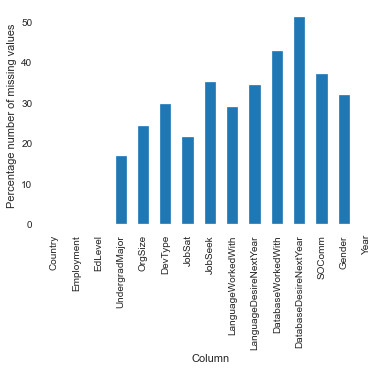

Year:  2018


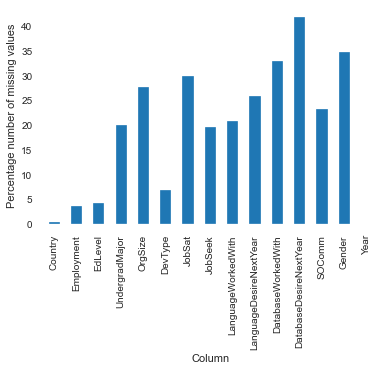

Year:  2019


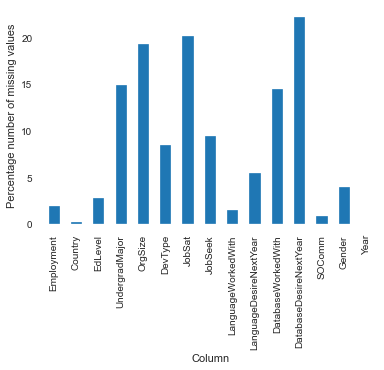

Year:  2020


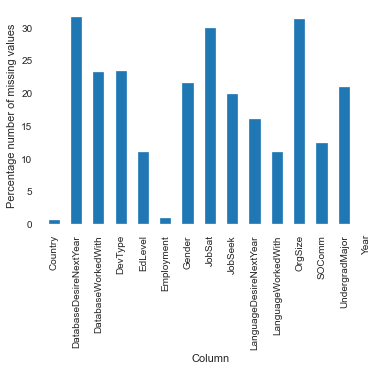

In [9]:
for year in years_df_dict_modified.keys():
    print('Year: ', year)
    df = years_df_dict_modified[year]
    rawDataManager.analyze_missing_values(df)

Year:  2017


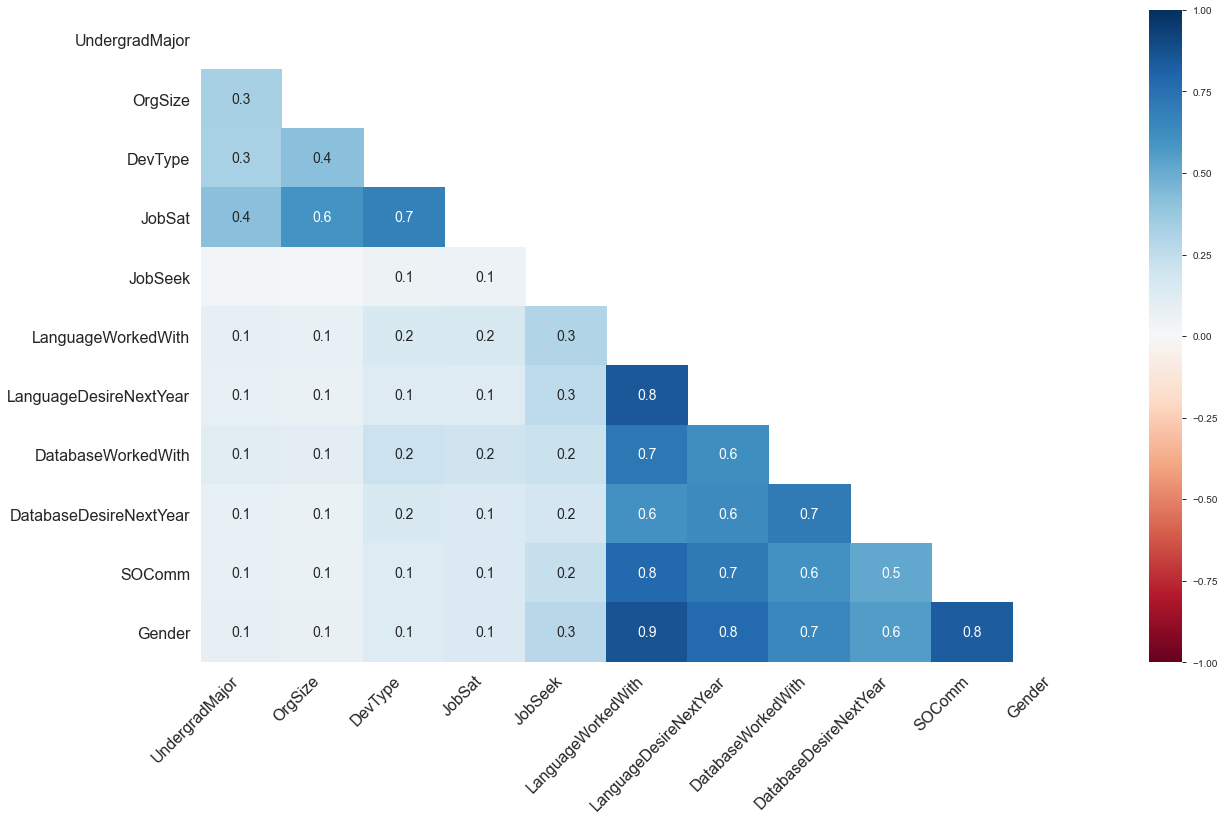

Year:  2018


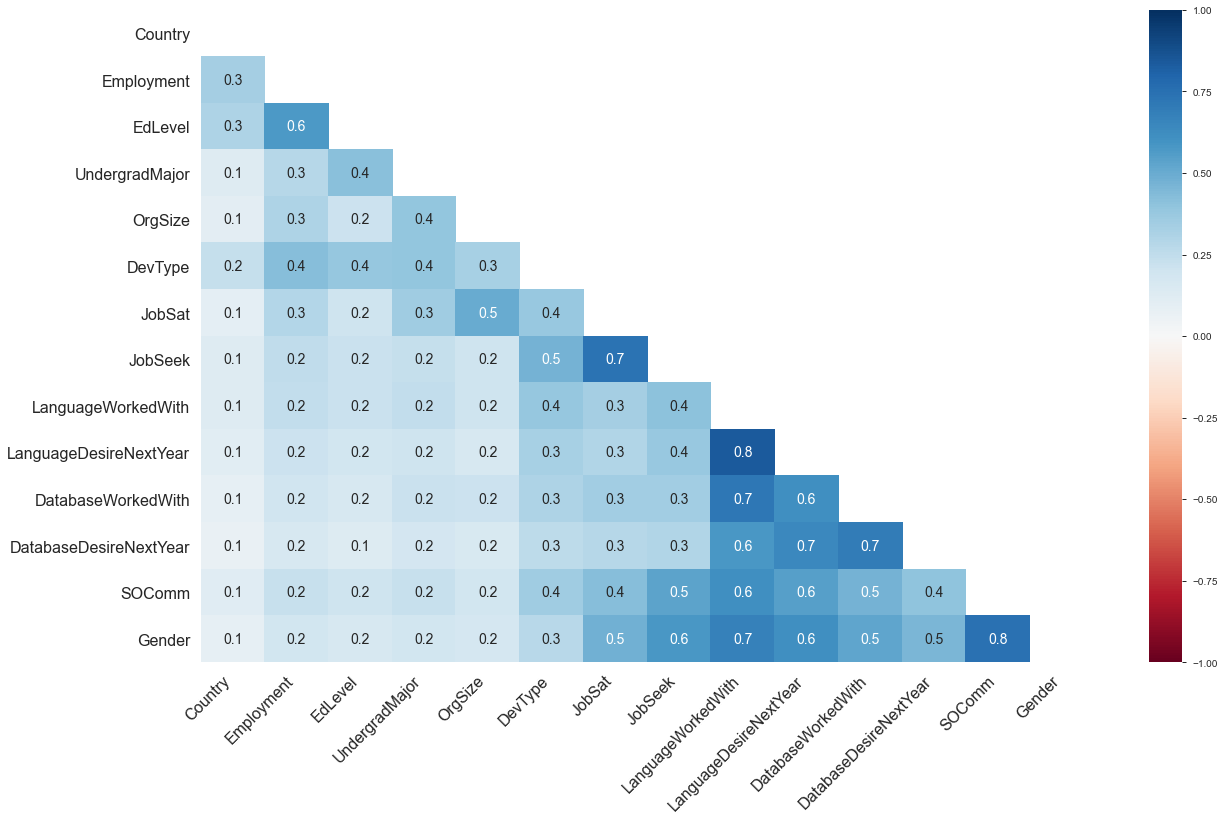

Year:  2019


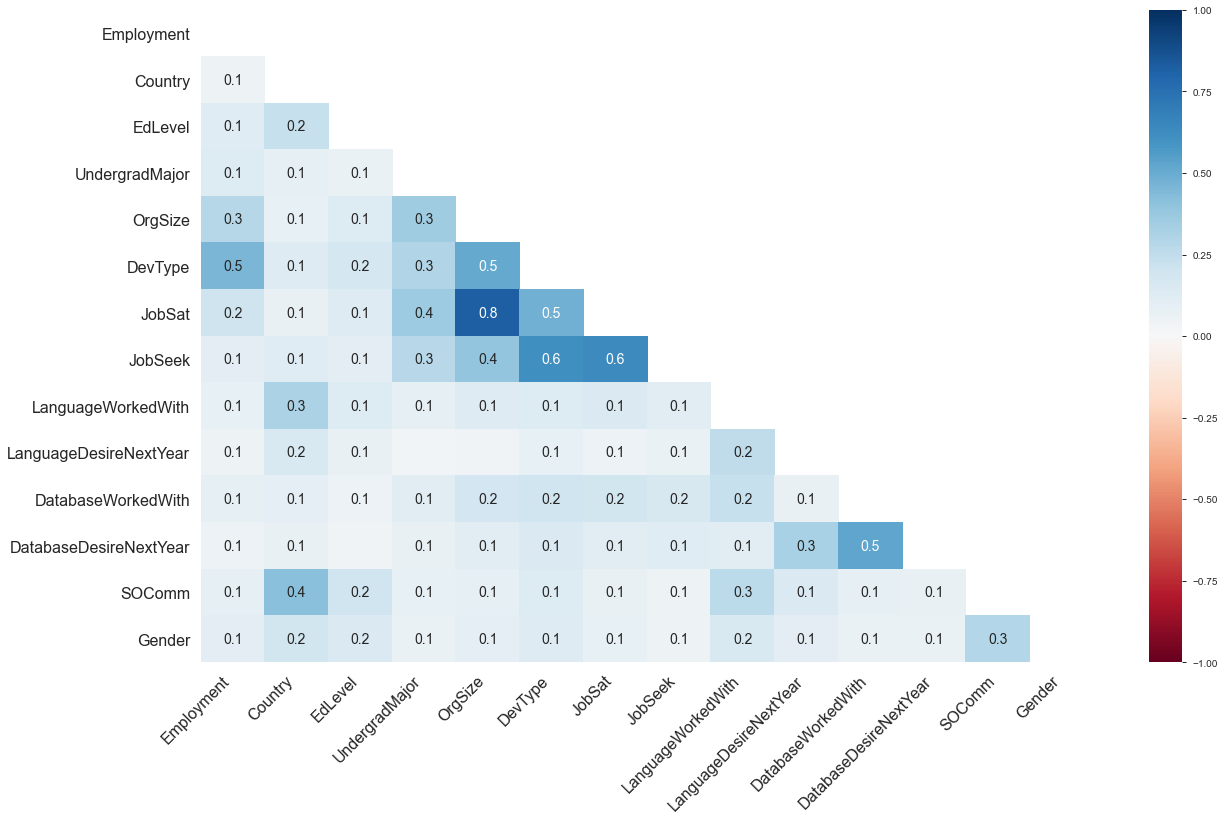

Year:  2020


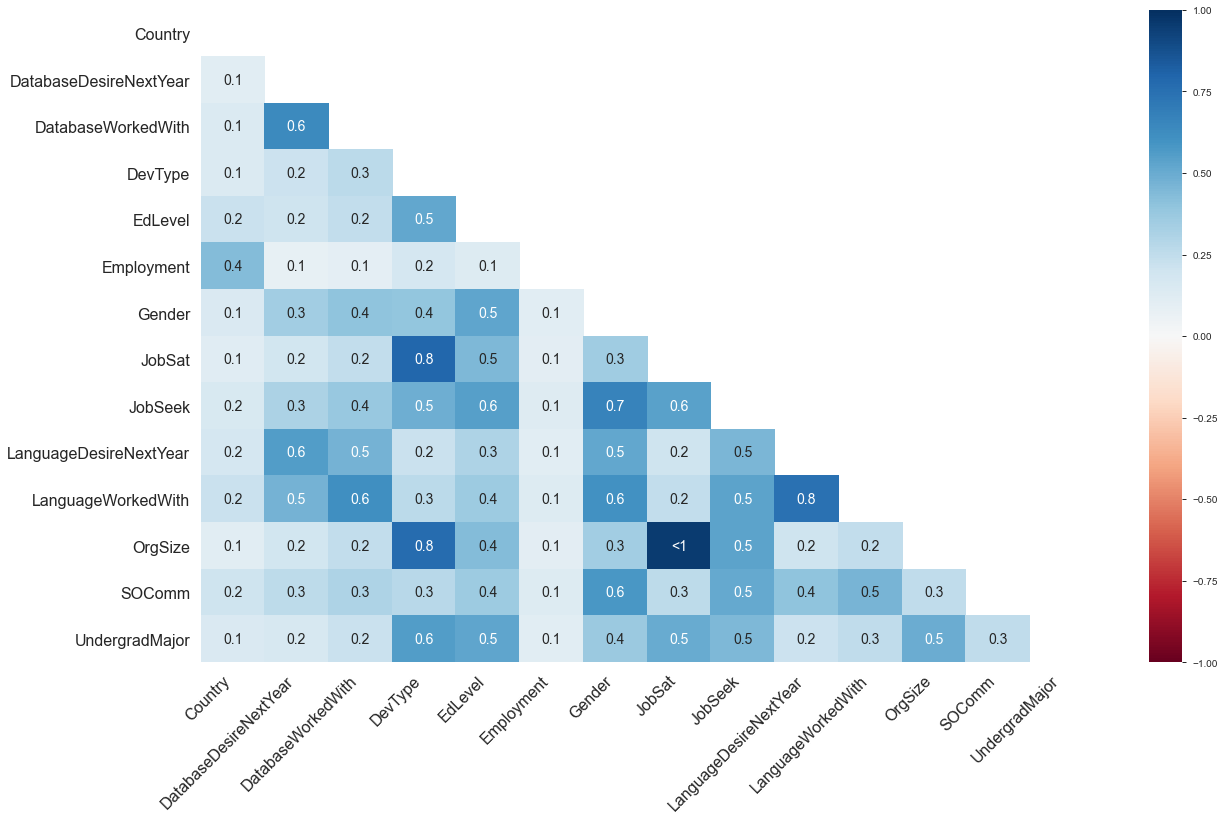

In [10]:
for year in years_df_dict_modified.keys():
    print('Year: ', year)
    df = years_df_dict_modified[year]
    rawDataManager.missing_values_correlation(df)

In [11]:
 rawDataManager.join_data_frames(years_df_dict_modified)

# Classes for managing the analysis of data

In [12]:
#Counter substrings in a delimited list of strings in the survey
class SubstringCounter:
    """
    A class representation of string counter.

    ...

    Attributes
    ----------
    __sub_strings : list
        list of strings after split by delimiter

    Methods
    -------
    set_sub_strings:
        splits and input strin seperated by delimiter into a list.
    count_sub_strings:
        counts strings by occurence in a list.
    """
    def __init__(self, delimiter=';', string_in=''):
        """
        constructs an instance of SubstringCounter.

        Parameters
        ----------
            string_in : str
                string of strings seperated by delimiter
            delimiter : str
                seperator substring
                
        Returns
        -------
        None
        """
        if string_in != None and len(string_in) > 0:
            self.__sub_strings = string_in.split(delimiter)
        else:
            self.__sub_strings = ''
    
    def set_sub_strings(self, string_in, delimiter=';'):
        """
        splits input string into substrings.

        Parameters
        ----------
            string_in : str
                string of strings seperated by delimiter
            delimiter : str
                seperator substring
                
        Returns
        -------
        None
        """
        if string_in != None and len(string_in) > 0:
            self.__sub_strings = string_in.split(delimiter)
        else:
            self.__sub_strings = ''
    
    def count_sub_strings(self, counts_dict):
        """
         counts strings by occurence.

        Parameters
        ----------
            counts_dict : dict()
                Counts the occurence of a substring in a string
                
        Returns
        -------
        None
        """
        if len(self.__sub_strings) > 0:
            for sub_string in self.__sub_strings:
                if sub_string != 'nan':
                    cnt = 0
                    sub_string_loc = sub_string.strip()
                    if not bool(counts_dict):
                        counts_dict[sub_string_loc] = cnt + 1
                    else:
                        if sub_string_loc in counts_dict.keys():
                            cnt = counts_dict[sub_string_loc] + 1
                            counts_dict.pop(sub_string_loc)
                            counts_dict[sub_string_loc] = cnt
                        else:
                            counts_dict[sub_string_loc] = cnt + 1

In [13]:
# Rank strings by number of occurence
class LanguageRanking:
    """
    representation of an object that performs ranking of strings by occurence.

    ...

    Attributes
    ----------
    __rankings : dict()
        store for raw rankings
    __blank: dict()
        store for blank entries i percent
    __rankings_as_percent : dict()
        store for job sat rankings in percent
    __rankings_as_percent_by_language : dict()
        store for job sat rankings in percent sorted in terms of the strings
    __substringCounter : SubstringCounter
        counts input strings by occurence
    __n_top_languages : int
        top n strings by occurence
        
    Methods
    -------
    set_number_of_top_languages_for_display():
        sets the number of top strings to display
    get_first_sorted_n_rankings():
        returns the top n raw ranking of strings by year in the survey
    get_first_sorted_n_percentage_rankings():
        returns the top n percentage ranking of strings by year in the survey
    set_rankings(self,  df_in, year()):
        performs the ranking of strings by occurence
    get_first_sorted_n_rankings_by_languages():
        returnthe top n languages in percent sorted by strings
        
    """
    def __init__(self, n=3): # n = 3 => first 3 top languages
        """
        constructs an instance of LanguageRanking.

        Parameters
        ----------
            n : int
                top n strins to display

        Returns
        -------
        None
        """
        self.__rankings = dict()
        self.__blank = dict() # store for counts of missing values
        self.__rankings_as_percent = dict()
        self.__rankings_as_percent_by_language = dict()
        self.__substringCounter =  SubstringCounter()
        self.__n_top_languages = n
     
    def set_number_of_top_languages_for_display(self, n):
        """
        set the number of strings to display by occurence

        Parameters
        ----------
            n : int
                number of top strings by occurence
                
        Returns
        -------
        None
        """
        self.__n_top_languages = n
        
    def get_first_sorted_n_rankings(self, year, n_elements):
        """
        return the top n strings by occurence for given year in the survey.

        Parameters
        ----------
            n_elements : int
                number of elements to return
            year : str
                year of interest
                
        Returns
        -------
        dictionary of strings and their raw scores
        """
        lang_dict = self.__rankings[year]
        sorted_rankings = dict(sorted(lang_dict.items(), key=operator.itemgetter(1),reverse=True))
        return dict(itertools.islice(sorted_rankings.items(), n_elements))
        
    def get_first_sorted_n_percentage_rankings(self, year, n_elements):
        """
        return the top n strings by occurence for given year in the survey.

        Parameters
        ----------
            n_elements : int
                number of elements to return
            year : str
                year of interest
                
        Returns
        -------
        dictionary of strings and their percentage scores
        """
        lang_dict = self.__rankings_as_percent[year]
        sorted_rankings = dict(sorted(lang_dict.items(), key=operator.itemgetter(1),reverse=True))
        return dict(itertools.islice(sorted_rankings.items(), n_elements))
    
    def get_first_sorted_n_rankings_by_languages(self):
        """
        return the top n strings by occurence for given year in the survey.

        Parameters
        ----------
            n_elements : int
                number of elements to return
            year : str
                year of interest
                
        Returns
        -------
        dictionary of strings and their percentage scores ordered by language and year
        """
        return self.__rankings_as_percent_by_language
    
    def __set_first_sorted_n_languages(self, year, dict_in, total_score):
        """
        performs sorting of scores order by language and year

        Parameters
        ----------
            dict_in : dict
                dictionary of rankings
            year : str
                year of interest
            total_score : float 
                total possible score for each string
                            
        Returns
        -------
        None
        """
        if bool(dict_in):
            sorted_rankings = dict(sorted(dict_in.items(), key=operator.itemgetter(1),reverse=True))
            n_elements_dict = dict(itertools.islice(sorted_rankings.items(), self.__n_top_languages))
            for language in n_elements_dict.keys():
                if bool(self.__rankings_as_percent_by_language):
                    if language in self.__rankings_as_percent_by_language.keys():
                        lang_by_year = self.__rankings_as_percent_by_language[language]
                        if year not in lang_by_year.keys():
                            lang_by_year[year] = round(100.0 * n_elements_dict[language] / total_score, 2)
                            self.__rankings_as_percent_by_language.pop(language)
                            self.__rankings_as_percent_by_language[language] = lang_by_year
                    else:
                        lang_by_year = dict()
                        lang_by_year[year] = round(100.0 * n_elements_dict[language] / total_score, 2)
                        self.__rankings_as_percent_by_language[language] = lang_by_year
                else:
                    lang_by_year = dict()
                    lang_by_year[year] = round(100.0 * n_elements_dict[language] / total_score, 2)
                    self.__rankings_as_percent_by_language[language] = lang_by_year
    
    def get_ranking(self):
        return self.__rankings
    
    def __check_key_in_dictionary(self, data_dict, key_token):
        if not bool(data_dict):
            return False
        else:
            if key_token in  data_dict.keys():
                return True
            else:
                return False
    
    def __set_blank_counts(self, year, df_in):
        """
        performs counts of missing values in a pandas dataframe column

        Parameters
        ----------
            df_in : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        if self.__check_key_in_dictionary(self.__blank, year) == False:
            blank_counts_srs = df_in.isnull().sum()
            self.__blank[year] =  blank_counts_srs['LanguageWorkedWith']
    
    def get_blank_rankings(self):
        return self.__blank
    
    def get_rankings_as_percentage(self):
        return self.__rankings_as_percent
    
    def __set_rankings_as_percent(self, lang_dict_in, year, total_score):
        """
        performs ranking of strings in percent by occurence

        Parameters
        ----------
            lang_dict_in : dict
                dictionary of rankings
            year : str
                year of interest
            total_score : float 
                total possible score for each string
                      
        Returns
        -------
        None
        """
        if bool(lang_dict_in):
            lang_dict = dict()
            for language in lang_dict_in.keys():
                score = lang_dict_in[language]
                percentage_score = 100.0 * score / total_score
                lang_dict[language] = round(percentage_score, 2)
            self.__rankings_as_percent[year] = lang_dict
            
    def set_rankings(self,  df_in, year):
        """
        performs rankings of languages for a year in the survey

        Parameters
        ----------
            df_in : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        languageWorkedWith_srs = df_in['LanguageWorkedWith']
        
        lang_dict = dict()
        for languageWorkedWith in  languageWorkedWith_srs.values:
            languageWorkedWith_loc = str(languageWorkedWith)
            self.__substringCounter.set_sub_strings(languageWorkedWith_loc)
            self.__substringCounter.count_sub_strings(lang_dict)
        self.__rankings[year] = lang_dict
        self.__set_blank_counts(year, df_in)
        
        # Treat  missing values as blanks and count them
        blank_counts_srs = df_in.isnull().sum()
        blanks_score =  blank_counts_srs['LanguageWorkedWith']
        
        self.__set_rankings_as_percent(lang_dict, year, float(len(df_in) - blanks_score))
        self.__set_first_sorted_n_languages(year, lang_dict, float(len(df_in) - blanks_score))

In [14]:
# Manage job satisfaction analysis in the survey
class JobSatData:
    """
    A class representation of job statisfaction data.

    ...

    Attributes
    ----------
    __high : dict
        dictionary of high job statisfaction scores
    __mdeium : dict
        dictionary of medium job statisfaction scores
    __low : dict
        dictionary of low job statisfaction scores
    __blank : dict
        dictionary of blank statisfaction entries

    Methods
    -------
    __set_blank_counts(self, year, df_in):
        count missing values as blanks
    __set_high_scores():
        set high job satisfaction scores
    __set_medium_scores():
        set medium job satisfaction scores
    __set_low_scores():
        set low job satisfaction scores
    set_counts(self, df, year):
        set job satisfaction scores
    """
    def __init__(self):
        """
        constructs an instance of JobSatData

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        self.__high = dict()
        self.__medium = dict()
        self.__low = dict()
        self.__blank = dict()
    
    def __check_key_in_dictionary(self, data_dict, key_token):
        if not bool(data_dict):
            return False
        else:
            if key_token in  data_dict.keys():
                return True
            else:
                return False
    
    def get_high_scores(self):
        return self.__high
    
    def get_medium_scores(self):
        return self.__medium
    
    def get_low_scores(self):
        return self.__low

    def get_blank_response(self):
        return self.__blank
    
    def __set_blank_counts(self, year, df_in):
        """
        performs counts of missing values in a pandas dataframe column

        Parameters
        ----------
            df_in : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        if self.__check_key_in_dictionary(self.__blank, year) == False:
            blank_counts_srs = df_in.isnull().sum()
            self.__blank[year] =  round(100.0 * blank_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_low_scores_for_2017(self, year, df_in):
        """
        """
        job_data_counts_srs = (df_in[(df_in.JobSat == 0)].count() + \
                               df_in[(df_in.JobSat == 1)].count() + \
                               df_in[(df_in.JobSat == 2)].count() + \
                               df_in[(df_in.JobSat == 3)].count() + \
                               df_in[(df_in.JobSat == 4)].count())
        
        self.__low[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_low_scores_for_2018(self, year, df_in):
        """
        """
        job_data_counts_srs = (df_in[(df_in.JobSat == 1)].count() + \
                               df_in[(df_in.JobSat == 2)].count() + \
                               df_in[(df_in.JobSat == 3)].count())
        self.__low[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_low_scores_for_2019_and_2020(self, year, df_in):
        """
        """
        job_data_counts_srs = (df_in[(df_in.JobSat == 1)].count() + \
                               df_in[(df_in.JobSat == 2)].count())
            
        self.__low[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
        
    def __set_medium_scores_for_2017(self, year, df_in):
        """
        """
        job_data_counts_srs = (df_in[(df_in.JobSat == 5)].count())
            
        self.__medium[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_medium_scores_for_2018(self, year, df_in):
        """
        """
        job_data_counts_srs = (df_in[(df_in.JobSat == 4)].count())
            
        self.__medium[year] = round(100.0 * job_data_counts_srs['JobSat']  / len(df_in), 2)
    
    def __set_medium_scores_for_2019_and_2020(self, year, df_in):
        """
        """
        job_data_counts_srs = (df_in[(df_in.JobSat == 3)].count())
            
        self.__medium[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
        
    def __set_high_scores_for_2017(self, year, df_in):
        """
        """
        job_data_counts_srs = (df_in[(df_in.JobSat == 6)].count() + \
                               df_in[(df_in.JobSat == 7)].count() + \
                               df_in[(df_in.JobSat == 8)].count() + \
                               df_in[(df_in.JobSat == 9)].count() + \
                               df_in[(df_in.JobSat == 10)].count())
            
        self.__high[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_high_scores_for_2018(self, year, df_in):
        """
        """
        job_data_counts_srs = (df_in[(df_in.JobSat == 5)].count() + \
                               df_in[(df_in.JobSat == 6)].count() + \
                               df_in[(df_in.JobSat == 7)].count())
            
        self.__high[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
    
    def __set_high_scores_for_2019_and_2020(self, year, df_in):
        """
        """
        job_data_counts_srs = (df_in[(df_in.JobSat == 4)].count() + \
                               df_in[(df_in.JobSat == 5)].count())
            
        self.__high[year] = round(100.0 * job_data_counts_srs['JobSat'] / len(df_in), 2)
            
    def __set_high_scores(self, year, df_in):
         """
        performs scoring of job satisfaction for entries above median

        Parameters
        ----------
            df_in : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
         if self.__check_key_in_dictionary(self.__high, year) == False:
                if year == '2017':
                    self.__set_high_scores_for_2017(year, df_in)
                elif year == '2018':
                    self.__set_high_scores_for_2018(year, df_in)
                elif year == '2019' or year == '2020':
                    self.__set_high_scores_for_2019_and_2020(year, df_in)
    
    def __set_medium_scores(self, year, df_in):
        """
        performs scoring of job satisfaction for entries at median

        Parameters
        ----------
            df_in : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        
        if self.__check_key_in_dictionary(self.__medium, year) == False:
            if year == '2017':
                self.__set_medium_scores_for_2017(year, df_in)
            elif year == '2018':
                self.__set_medium_scores_for_2018(year, df_in)
            elif year == '2019' or year == '2020':
                self.__set_medium_scores_for_2019_and_2020(year, df_in)
    
    def __set_low_scores(self, year, df_in):
        """
        performs scoring of job satisfaction for entries below median

        Parameters
        ----------
            df_in : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        if self.__check_key_in_dictionary(self.__low, year) == False:
            if year == '2017':
                self.__set_low_scores_for_2017(year, df_in)
            elif year == '2018':
                self.__set_low_scores_for_2018(year, df_in)
            elif year == '2019' or year == '2020':
                self.__set_low_scores_for_2019_and_2020(year, df_in)
            
    def __set_blank_scores(self, year, df_in):
        """
        performs counts of missing values in a pandas dataframe column

        Parameters
        ----------
            df_in : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        blank_counts_srs = df_in.isnull().sum()
        self.__blank[year] =  round(100.0 * blank_counts_srs['JobSat'] / len(df_in), 2)         
    
    def set_counts(self, df, year):
        """
        performs scoring of job satisfaction entries

        Parameters
        ----------
            df : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        self.__set_medium_scores(year, df)
        self.__set_high_scores(year, df)
        self.__set_low_scores(year, df)
        self.__set_blank_scores(year, df)
      

In [15]:
# Manage data for gender response for a country in the survey
class GendaCountsData:
    """
    A class representation of gender response data

    ...

    Attributes
    ----------
    __counts_male : dict
        dictionary of count of male responders counts
    __counts_female : dict
        dictionary of male count of female responders
    __gender_neutral : dict
        dictionary of male count of gender neutral responders
    __blank : dict
        dictionary of blank statisfaction entries

    Methods
    -------
     __set_blank_counts(self, year, df_in):
        count missing values as blanks
     __set_counts_for_gender_neutral():
        set counts of gender neutral responders
     __set_counts_female():
        set counts of female responders
     __set_counts_male():
        set counts of male responders
     set_counts(self, df, year):
        set gender response counts for all
    """
    def __init__(self):
        """
        constructs an instance of GendaCountsData

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        self.__counts_male = dict()
        self.__counts_female = dict()
        self.__gender_neutral = dict()
        self.__blank = dict()
    
    def __check_key_in_dictionary(self, data_dict, key_token):
        if not bool(data_dict):
            return False
        else:
            if key_token in  data_dict.keys():
                return True
            else:
                return False
    
    def get_females_response(self):
        return self.__counts_female
    
    def get_males_response(self):
        return self.__counts_male
    
    def get_gender_neutral_response(self):
        return self.__gender_neutral
    
    def get_blank_response(self):
        return self.__blank
    
    def __set_blank_counts(self, year, df_in):
        """
        performs counts of missing values in a pandas dataframe column

        Parameters
        ----------
            df_in : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        blank_counts_srs = df_in.isnull().sum()
        self.__blank[year] =   round(100.0 * blank_counts_srs['Gender'] / len(df_in), 2)
        
    def __set_counts_for_gender_neutral(self, year, df_in):
        """
        performs counts of entries for gender neutral responses in the dataframe

        Parameters
        ----------
            df : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        if self.__check_key_in_dictionary(self.__gender_neutral, year) == False:
            all_counts_srs = df_in.count()
            female_counts_srs = (df_in[(df_in.Gender == 'Woman')].count() + \
                                df_in[(df_in.Gender == 'woman')].count() + \
                                df_in[(df_in.Gender == 'Female')].count() + \
                                df_in[(df_in.Gender == 'female')].count())
            
            male_counts_srs = (df_in[(df_in.Gender == 'Man')].count() + \
                               df_in[(df_in.Gender == 'man')].count() + \
                               df_in[(df_in.Gender == 'Male')].count() + \
                               df_in[(df_in.Gender == 'male')].count())
            
            neutral_gender_count = all_counts_srs['Gender'] - (male_counts_srs['Gender'] + female_counts_srs['Gender'])
            self.__gender_neutral[year] =  round(100.0 * neutral_gender_count / len(df_in), 2)
        
    def __set_counts_female(self, year, df_in):
        """
        performs counts of entries for female responses in the dataframe

        Parameters
        ----------
            df : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        if self.__check_key_in_dictionary(self.__counts_female, year) == False:
            counts_df = (df_in[(df_in.Gender == 'Woman')].count() + \
                         df_in[(df_in.Gender == 'woman')].count() + \
                         df_in[(df_in.Gender == 'Female')].count() + \
                         df_in[(df_in.Gender == 'female')].count())
            self.__counts_female[year] = round(100.0 * counts_df['Gender'] / len(df_in), 2)
    
    def __set_counts_male(self, year, df_in):
        """
        performs counts of entries for male responses in the dataframe

        Parameters
        ----------
            df : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        if self.__check_key_in_dictionary( self.__counts_male, year) == False:
            counts_df = (df_in[(df_in.Gender == 'Man')].count() + \
                        df_in[(df_in.Gender == 'man')].count() + \
                        df_in[(df_in.Gender == 'Male')].count() + \
                        df_in[(df_in.Gender == 'male')].count())
            self.__counts_male[year] =  round(100.0 * counts_df['Gender'] / len(df_in), 2)
            
    def set_counts(self, df, year):
        """
        performs counts responses for gender classes

        Parameters
        ----------
            df : dataframe
                pandas datrame of values
            year : str
                year of interest
                
        Returns
        -------
        None
        """
        self.__set_counts_male(year, df)
        self.__set_counts_female(year, df)
        self.__set_counts_for_gender_neutral(year, df)
        self.__set_blank_counts(year, df)

In [16]:
# manage the response data for a country in the survey
class CountryReponseData:
    """
    A class representation of the response data for a country in the survey

    ...

    Attributes
    ----------
    __response_counts_dict : dict
        dictionary of response counts for the year
    __genda_counts_data : GendaCountsData
        instance of GendaCountsData
    __job_sat_data : JobSatData
        instance of JobSatData
    __languageRanking :  LanguageRanking
        instance of  LanguageRanking

    Methods
    -------
     set_job_sat_scores():
        sets the job satisfaction scores for the given country
     set_gender_counts():
        sets the gender response scores for the given country
     set_language_rankings:
        sets the programming language rankings for the given country
     set_response_counts():
        sets the total number of rsponses for the given country
    """
        
    def __init__(self):
        """
        constructs an instance of CountryReponseData

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        
        self.__response_counts_dict = dict()
        self.__genda_counts_data = GendaCountsData()
        self.__job_sat_data = JobSatData()
        self.__languageRanking = LanguageRanking()
        self.__response_years_set = set()
    
    def __check_key_in_dictionary(self, data_dict, key_token):
        if not bool(data_dict):
            return False
        else:
            if key_token in  data_dict.keys():
                return True
            else:
                return False
    
    def set_response_year(self, year):
        self.__response_years_set.add(year)
        
    def get_response_year(self):
        return __response_years_set
    
    def set_gender_counts(self, df, year):
        self.__genda_counts_data.set_counts(df, year)
        
    def set_job_sat_scores(self, df, year):
        self.__job_sat_data.set_counts(df, year)
    
    def set_language_rankings(self, df, year):
        self.__languageRanking.set_rankings(df, year)
        
    def set_response_counts(self, counts, year):
        if self.__check_key_in_dictionary(self.__response_counts_dict, year) == False:
            self.__response_counts_dict[year] = counts
    
    def get_gender_response(self):
        return self.__genda_counts_data
    
    def get_job_sat_scores(self):
        return self.__job_sat_data
    
    def get_response_counts(self):
        return self.__response_counts_dict
    
    def get_language_rankings(self):
        return self.__languageRanking 

In [17]:
# manage response data and general information for a country in the survey
class CountryData:
    """
    A class representation for managing and controlling the response data of a country in the survey

    ...

    Attributes
    ----------
    __country_name : str
        name of country in the survey
    __alpha_country_code : str
        alpha code for a country eg USA
    __alpha_continent_code : str
        alpha continent code for a country eg North America
    __latitude : float
        the latitude of the country in a map
    __longitude : float
        the longitude of the country in a map
    __response_data : dict()
        store for CountryReponseData instances   
    Methods
    -------
     set_alpha_country_code(self):
        sets the alpha code for a country
     set_alpha_continent_code(self):
        sets the alpha continent code for a country
     has_latitude_and_longitude:
        checks if it was possible to obtain the latitude and longitude for a country in the survey
     compute_country_data(self, year, df, response_type_str):
        controls the computation of selected yearly response statistics for a country
     __set_yearly_gender_rsponse(self, year, country_data_df, response_type_str):
        controls the computation of yearly gender response statistics for a country
     __set_yearly_job_sat_scores:
         controls the computation of yearly job satsisfaction scores for acountry
     __set_yearly_languange_rankings:
         controls the computation of yearly language rankings for acountry
     __set_yearly_response_counts():
         controls the computation of total yearly response data for acountry
    """
    
    def __init__(self, country_name):
        """
        constructs an instance of CountryData

        Parameters
        ----------
            country_name : str
                name of the country in the survey

        Returns
        -------
        None
        """
        
        self.__country_name = country_name
        self.__alpha_country_code = None
        self.__alpha_continent_code = None
        self.__latitude = None
        self.__longitude = None
        self.__response_data = dict()
    
    def set_country_name(self, country_name):
        self.__country_name = country_name
        
    def get_country_name(self):
        return self.__country_name
        
    def set_alpha_country_code(self):
        """
        sets the alpha code for a country

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        
        try:
            self.__alpha_country_code =  country_name_to_country_alpha2(self.__country_name)
        except:
            self.__alpha_country_code = None
            print('Unable to set: self.alpha_country_code')
    
    def get_alpha_country_code(self):
        return self.__alpha_country_code
    
    def set_alpha_continent_code(self):
        """
        sets the alpha continent code for a country

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        
        try:
            self.__alpha_continent_code = country_alpha2_to_continent_code(self.__alpha_country_code)
        except:
            self.__alpha_continent_code = None
            print('Unable to set: self.alpha_continent_code')   
    
    def get_alpha_continent_code(self):
        return self.__alpha_continent_code 
            
    def get_country_and_continent_codes_as_pair(self):
        return (self.__alpha_country_code, self.__alpha_continent_code)
    
    def get_latitude(self):
        return self.__latitude
    
    def get_longitude(self):
        return self.__longitude
    
    def set_country_coordinates(self):
        """
        sets the latitude and longitude for a country

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        geolocator = Nominatim(user_agent="on_explorer")
        try: 
            area_address = self.__country_name + ', ' + self.__alpha_country_code
            area_location = geolocator.geocode(area_address)
            self.__latitude = area_location.latitude
            self.__longitude =  area_location.longitude
        except:
            self.__latitude = np.nan
            self.__longitude = np.nan
            print('Unable to get latitude and longitude for: ', self.__country_name)
    
    def has_latitude_and_longitude(self):
        if self.__longitude is not np.nan and self.__latitude is not np.nan:
            return True
        else:
            return False
        
    def __check_key_in_dictionary(self, key_token):
        if not bool(self.__response_data):
            return False
        else:
            if key_token in self.__response_data.keys():
                return True
            else:
                return False
            
    def compute_country_data(self, year, df, response_type_str):
        """
        controls the computation of selected yearly response statistics for a country

        Parameters
        ----------
            year : str
                year of interest
            df : dataframe
                pandas dataframe of response data
            response_type_str : str
                type of response statistic to compute

        Returns
        -------
        None
        """
        
        country_data_df = df[df.Country == self.__country_name]
        if response_type_str == 'yearly_response_counts':
            self.__set_yearly_response_counts(year, country_data_df, response_type_str)
        elif response_type_str == 'gender_counts':
            self.__set_yearly_gender_rsponse(year, country_data_df, response_type_str)
        elif response_type_str == 'JobSat':
            self.__set_yearly_job_sat_scores(year, country_data_df, response_type_str)
        elif response_type_str == 'lang_ranking':
            self. __set_yearly_languange_rankings(year, country_data_df, response_type_str)

    def get_response_data(self):
        return self.__response_data
    
    def __set_yearly_gender_rsponse(self, year, country_data_df, response_type_str):
        """
        controls the computation of yearly gender response statistics for a country

        Parameters
        ----------
            year : str
                year of interest
            country_data_df : dataframe
                pandas dataframe of response data
            response_type_str : str
                type of response statistic to compute

        Returns
        -------
        None
        """
        
        if self.__check_key_in_dictionary(response_type_str) == False:
            countryReponseData = CountryReponseData()
            countryReponseData.set_response_year(year)
            countryReponseData.set_gender_counts(country_data_df, year)
            self.__response_data[response_type_str] = countryReponseData 
        else:
            countryReponseData = self.__response_data[response_type_str]
            countryReponseData.set_response_year(year)
            countryReponseData.set_gender_counts(country_data_df, year)
            self.__response_data.pop(response_type_str)
            self.__response_data[response_type_str] = countryReponseData 
    
    def __set_yearly_job_sat_scores(self, year, country_data_df, response_type_str):
        """
        controls the computation of yearly job statisfaction scores for a country

        Parameters
        ----------
            year : str
                year of interest
            country_data_df : dataframe
                pandas dataframe of response data
            response_type_str : str
                type of response statistic to compute

        Returns
        -------
        None
        """
        
        if self.__check_key_in_dictionary(response_type_str) == False:
            countryReponseData = CountryReponseData()
            countryReponseData.set_response_year(year)
            countryReponseData.set_job_sat_scores(country_data_df, year)
            self.__response_data[response_type_str] = countryReponseData 
        else:
            countryReponseData = self.__response_data[response_type_str]
            countryReponseData.set_response_year(year)
            countryReponseData.set_job_sat_scores(country_data_df, year)
            self.__response_data.pop(response_type_str)
            self.__response_data[response_type_str] = countryReponseData 
    
    def __set_yearly_languange_rankings(self, year, country_data_df, response_type_str):
        """
        controls the computation of yearly language rankings for a country

        Parameters
        ----------
            year : str
                year of interest
            country_data_df : dataframe
                pandas dataframe of response data
            response_type_str : str
                type of response statistic to compute

        Returns
        -------
        None
        """
        
        if self.__check_key_in_dictionary(response_type_str) == False:
            countryReponseData = CountryReponseData()
            countryReponseData.set_response_year(year)
            countryReponseData.set_language_rankings(country_data_df, year)
            self.__response_data[response_type_str] = countryReponseData 
        else:
            countryReponseData = self.__response_data[response_type_str]
            countryReponseData.set_response_year(year)
            countryReponseData.set_language_rankings(country_data_df, year)
            self.__response_data.pop(response_type_str)
            self.__response_data[response_type_str] = countryReponseData
            
    def __set_yearly_response_counts(self, year, country_data_df, response_type_str):
        """
        controls the computation of total yearly response values for a country

        Parameters
        ----------
            year : str
                year of interest
            country_data_df : dataframe
                pandas dataframe of response data
            response_type_str : str
                type of response statistic to compute

        Returns
        -------
        None
        """
        
        if self.__check_key_in_dictionary(response_type_str) == False:
            countryReponseData = CountryReponseData()
            countryReponseData.set_response_year(year)
            countryReponseData.set_response_counts(country_data_df.Country.count(), year)
            self.__response_data[response_type_str] = countryReponseData
        else:
            countryReponseData = self.__response_data[response_type_str]
            countryReponseData.set_response_year(year)
            countryReponseData.set_response_counts(country_data_df.Country.count(), year)
            self.__response_data.pop(response_type_str)
            self.__response_data[response_type_str] = countryReponseData

In [18]:
# manage data for all countries in list from the survey
class CountriesDataManager:
    """
    A class representation for managing and controlling the response data of countries 
    
    ...
    
    Attributes
    ----------
    __countries_dict : dict()
        store data for countires in the survey
     Methods
    -------
    compute_countries_data(self, rawDataManager_in, response_type_str_list):
        controls the computation of selected yearly response statistics for countries
    __init_country_data(self, country_name)
        initializes general data for each country in the survey
    """
    
    def __init__(self):
        self.__countries_dict = dict()
    
    def __check_key_in_dictionary(self, key_token):
        if not bool(self.__countries_dict):
            return False
        else:
            if key_token in self.__countries_dict.keys():
                return True
            else:
                return False
    
    def compute_countries_data(self, rawDataManager_in, response_type_str_list):
        """
        controls the computation of yearly response statistics for countries in the survey

        Parameters
        ----------
            rawDataManager_in : RawDataManager
                instance of RawDataManager
            response_type_str : str
                type of response statistic to compute

        Returns
        -------
        None
        """
        for year in rawDataManager.years_under_analysis:
            df = rawDataManager_in.df_concat.loc[year]
            unique_country_names = df['Country'].unique() 
            for unique_country_name in unique_country_names:
                if self.__check_key_in_dictionary(unique_country_name) == False:
                    countryData = self.__init_country_data(unique_country_name)
                    if countryData.has_latitude_and_longitude():
                        self.__compute_data_for_country(year, df, countryData, response_type_str_list)
                        self.__countries_dict[unique_country_name] = countryData
                else:
                    countryData = self.__countries_dict[unique_country_name]
                    if countryData.has_latitude_and_longitude():
                        self.__compute_data_for_country(year, df, countryData, response_type_str_list)
                        self.__countries_dict.pop(unique_country_name)
                        self.__countries_dict[unique_country_name] = countryData
                   
    def __init_country_data(self, country_name): 
        """
       initializes general data for each country in the survey

        Parameters
        ----------
            rawDataManager_in : RawDataManager
                instance of RawDataManager
            country_nam : str
                name of country

        Returns
        -------
         instance of CountryData
        """
        countryData = CountryData(country_name)
        countryData.set_alpha_country_code()
        countryData.set_alpha_continent_code()
        countryData.set_country_coordinates()
        return countryData
    
    def get_coutries_data_dict(self):
        return self.__countries_dict
    
    def __compute_data_for_country(self, year, df, countryData, response_type_str_list):
        for response_type_str in response_type_str_list:
            countryData.compute_country_data(year, df, response_type_str)
        
    def get_country_names_as_list(self):
        return list(self.__countries_dict.keys())
    
    def get_countries_data_as_list(self):
        return list(self.__countries_dict.values())
    
    def get_country_data(self, country_name):
        return self.__countries_dict[country_name]
    
    def get_country_response_type_data(self, country_name, response_type_str): # Total number of response for country and year
        country_data = self.__countries_dict[country_name]
        countryReponseData = country_data.get_response_data()[response_type_str]
        return countryReponseData.get_response_counts()
    
    def get_gender_response_type_data(self, country_name, response_type_str):  # number of male, female response for country and year
        country_data = self.__countries_dict[country_name]
        countryReponseData = country_data.get_response_data()[response_type_str]
        return countryReponseData.get_gender_response()
    
    def get_job_sat_scores(self, country_name, response_type_str):  # job satisfaction scores
        country_data = self.__countries_dict[country_name]
        countryReponseData = country_data.get_response_data()[response_type_str]
        return countryReponseData.get_job_sat_scores()
    
    def get_yearly_language_rankings(self, country_name, response_type_str):
        country_data = self.__countries_dict[country_name]
        countryReponseData = country_data.get_response_data()[response_type_str]
        return countryReponseData.get_language_rankings()

# Analysis
Computations are done for the followings:
<ul>
<li>total response counts for each country for each year</li>
<li>gender response counts for each country for each year</li>
<li>job satisfaction scores for each country for each year</li>
<li>top three programming languages for each country for each year</li>
</ul>

In [19]:
countriesDataManager = CountriesDataManager()

In [20]:
# total response counts for each country for each year
# gender response counts for each country for each year
# job satisfaction scores for each country for each year
# three top programming languages for each country for each year

response_types_list = ['yearly_response_counts', 'gender_counts', 'JobSat', 'lang_ranking']
countriesDataManager.compute_countries_data(rawDataManager, response_types_list)

Unable to get latitude and longitude for:  India
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  I prefer not to say
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  Moldavia
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  Bosnia-Herzegovina
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  Netherlands Antilles
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  Virgin Islands (USA)
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and longitude for:  Aland Islands
Unable to set: self.alpha_country_code
Unable to set: self.alpha_continent_code
Unable to get latitude and lo

In [21]:
# general information for each country in the yearly survey
column_names = ['Country', 'Latitude', 'Longitude']   
locations_list = list()
for country_name in countriesDataManager.get_coutries_data_dict().keys():
    country_data_loc = countriesDataManager.get_coutries_data_dict()[country_name]
    locations_list.append([country_data_loc.get_country_name(), \
                           country_data_loc.get_latitude(), \
                           country_data_loc.get_longitude()])

locations_df = pd.DataFrame(locations_list, columns=column_names)

In [22]:
locations_df.head(20)

,Country,Latitude,Longitude
0,Slovak Republic,48.741152,19.452865
1,Vietnam,13.290403,108.426511
2,Macedonia,41.617121,21.716839
3,Bermuda,32.301822,-64.760358
4,American Samoa,-14.289304,-170.692511
5,Puerto Rico,18.391347,-66.890479
6,Hong Kong,22.279328,114.162813
7,Venezuela,8.001871,-66.110932
8,Cayman Islands,19.541721,-80.566713
9,Syria,34.640186,39.049411


In [23]:
countries_with_locations = locations_df['Country']

In [24]:
countries_with_locations

0       Slovak Republic
1               Vietnam
2             Macedonia
3               Bermuda
4        American Samoa
             ...       
203         Timor-Leste
204     Solomon Islands
205          Cape Verde
206               Gabon
207    Marshall Islands
Name: Country, Length: 208, dtype: object

## utility methods for data presentation

In [25]:
def create_single_vincent_bar_chart(data_df, xlabel_in, ylabel_in,  bar_width=150, bar_height=250):
    """
        performs the creation of a vincent bar chart

        Parameters
        ----------
           data_df : dataframe
                
        Returns
        -------
        bar
    """
    bar = vincent.Bar(data_df.iloc[:,0])
    bar.axis_titles(x=xlabel_in, y=ylabel_in)
    bar.width = bar_width
    bar.height = bar_height
    return bar

In [26]:
# create vincent bar charts and store in json files for countries in the survey 
def create_vincent_bar_chart(df_in, countries_with_locations_srs, file_name_addendum, response_type_str):
    """
        performs the creation of a vincent bar charts for inclusion in a map

        Parameters
        ----------
           df_in : dataframe
           response_type_str : str
               type of statistic
           countries_with_locations_srs : series
               pandas series of values for countries
           file_name_addendum: str
                jason file indicator
        Returns
        -------
        returns a modified copy of df_in
    """
    json_files_list = list()
    for country in countries_with_locations_srs.values:
        country_response_counts_dict = countriesDataManager.get_country_response_type_data(country, \
                                                                                           response_type_str)
        index_list = list(country_response_counts_dict.keys())
        country_values_df = pd.DataFrame(list(country_response_counts_dict.values()), index=index_list)
        country_bar = create_single_vincent_bar_chart(country_values_df, 'Year', 'Number of responses')
        json_file = country + '_'+ file_name_addendum + '.json'
        country_bar.to_json(json_file)
        json_files_list.append(json_file)
    df_copy = df_in.copy()
    df_copy['json_file'] = json_files_list
    return df_copy

In [27]:
def plot_map(locations_df_in, popup_max_width=350, child_width=300):
    """
        plot the map of countries in the survey

        Parameters
        ----------
           locations_df_in : dataframe 
        
        Returns
        -------
        returns a folium map
    """
    global_survey_data_map = folium.Map(tiles="cartodbpositron",  zoom_start=11)
    for i in range(len(locations_df)):
        lat = locations_df.iloc[i]['Latitude']
        long = locations_df.iloc[i]['Longitude']
        folium.Marker(
        location = [lat, long],
        popup=folium.Popup(max_width=popup_max_width).add_child(\
                                                    folium.Vega(json.load(open(locations_df_in.iloc[i]['json_file'])), \
                                                    width=child_width, height=300))
        ).add_to(global_survey_data_map)
    return global_survey_data_map

In [28]:
def save_map_as_image(map_data, file_name):
    """
        save a map as an image

        Parameters
        ----------
           map_dat : folium map
           file_name : str
               name of file for map image
        
        Returns
        -------
        returns a folium map
    """
    delay=10
    #Save the map as an HTML file
    fn = file_name + '.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    map_data.save(fn)
    #Open a browser window...
    browser = webdriver.Firefox(executable_path='C:\\development\\windows-share\\stack-overflow-survey\\geckodriver.exe')
    #..that displays the map...
    browser.get(tmpurl)
    #Give the map tiles some time to load
    time.sleep(delay)
    #Grab the screenshot
    browser.save_screenshot(file_name + '.png')
    #Close the browser
    browser.quit()

In [29]:
def create_vincent_grouped_bar(data_df, xlabel_in, ylabel_in, bar_width, bar_height, legend_in):
    """
        performs the creation of a grouped vincent bar chart

        Parameters
        ----------
           df_in : dataframe
                
        Returns
        -------
        bar
    """
    bar = vincent.GroupedBar(data_df)
    bar.axis_titles(x=xlabel_in, y=ylabel_in)
    bar.width = bar_width
    bar.height = bar_height
    bar.legend(title=legend_in)
    return bar

In [30]:
def plot_vincent_grouped_bar(dict_of_data_dict, xlabel_in, ylabel_in, bar_width, bar_height, legend_in='Years'):
    data_list = []
    index_list = []
    
    """
        manages the creationof grouped bar charts

        Parameters
        ----------
           dict_of_data_dict : dictionary of dictionaries
                
        Returns
        -------
        bar
    """
    for key in dict_of_data_dict.keys():
        data_loc = dict_of_data_dict[key]
        data_list.append(data_loc)
        index_list.append(key)
    data_df = pd.DataFrame(data_list, index=index_list)
    bar_loc = create_vincent_grouped_bar(data_df, 
                                         xlabel_in, 
                                         ylabel_in, 
                                         bar_width, 
                                         bar_height, 
                                         legend_in)
    return bar_loc

## Total yearly response counts for all countries in the survey.

In [31]:
locations_df_modified =  create_vincent_bar_chart(locations_df, 
                                                  countries_with_locations,  
                                                  'response',
                                                  'yearly_response_counts')

In [32]:
locations_df_modified

,Country,Latitude,Longitude,json_file
0,Slovak Republic,48.741152,19.452865,Slovak Republic_response.json
1,Vietnam,13.290403,108.426511,Vietnam_response.json
2,Macedonia,41.617121,21.716839,Macedonia_response.json
3,Bermuda,32.301822,-64.760358,Bermuda_response.json
4,American Samoa,-14.289304,-170.692511,American Samoa_response.json
...,...,...,...,...
203,Timor-Leste,-8.515198,125.837576,Timor-Leste_response.json
204,Solomon Islands,-9.735434,162.828854,Solomon Islands_response.json
205,Cape Verde,16.000055,-24.008395,Cape Verde_response.json
206,Gabon,-0.899969,11.689970,Gabon_response.json


###  yearly response counts by country

In [33]:
# plot the map of the countries with the total yearly response counts for each country 
global_survey_data_map = plot_map(locations_df_modified)

In [34]:
global_survey_data_map

In [35]:
#save_map_as_image(global_survey_data_map, 'global_survey_data_map')

### show response counts data for selected countries that are in the map

In [36]:
response_counts_dict_sweden = countriesDataManager.get_country_response_type_data('Sweden', 'yearly_response_counts')

In [37]:
index_list_sweden = list(response_counts_dict_sweden.keys())
values_df_sweden = pd.DataFrame(list(response_counts_dict_sweden.values()), index=index_list_sweden) 
values_df_sweden

,0
2017,611
2018,1164
2019,1274
2020,886


In [38]:
response_bar_sweden = create_single_vincent_bar_chart(values_df_sweden, 'Year', 'Number of responses')
response_bar_sweden.display()

In [39]:
response_counts_dict_usa = countriesDataManager.get_country_response_type_data('United States', 'yearly_response_counts')

In [40]:
index_list_usa = list(response_counts_dict_usa.keys())
values_df_usa = pd.DataFrame(list(response_counts_dict_usa.values()), index=index_list_usa) 
values_df_usa

,0
2017,11455
2018,20309
2019,20949
2020,12469


In [41]:
response_bar_usa = create_single_vincent_bar_chart(values_df_usa, 'Year', 'Number of responses')
response_bar_usa.display()

## Total yearly gender response by country

In [42]:
def get_dict_of_dict_gender_response(gender_response_in):
    dict_data_dict = dict()
    dict_data_dict['Females'] = gender_response_in.get_females_response()
    dict_data_dict['Males'] = gender_response_in.get_males_response()
    dict_data_dict['Neutral'] = gender_response_in.get_gender_neutral_response()
    dict_data_dict['Blank'] = gender_response_in.get_blank_response()
    return dict_data_dict

In [43]:
def create_vincent_gender_bar_chart(df_in, countries_with_locations_srs, file_name_addendum, response_type_str):
    """
        manages the creation of grouped bar charts for gender response

        Parameters
        ----------
           dict_of_data_dict : dictionary of dictionaries
                
        Returns
        -------
        bar
    """
    
    json_files_list = list()
    dict_data_dict = dict()
    
    for country in countries_with_locations_srs.values:
        gender_response_loc = countriesDataManager.get_gender_response_type_data(country, response_type_str)
        
        dict_data_dict = get_dict_of_dict_gender_response(gender_response_loc)
        
        bar = plot_vincent_grouped_bar(dict_data_dict, 
                                       'Gender', 
                                       'Percentage Number of Responses', 
                                       150, 
                                       250)
        
        json_file = country + '_'+ file_name_addendum + '.json'
        bar.to_json(json_file)
        json_files_list.append(json_file)
    df_copy = df_in.copy()
    df_copy['json_file'] = json_files_list
    return df_copy

In [44]:
locations_df_modified_gender = create_vincent_gender_bar_chart(locations_df, 
                                                               countries_with_locations, 
                                                               'gender', 
                                                               'gender_counts')

In [45]:
global_gender_response_map = plot_map(locations_df_modified_gender)

In [46]:
global_gender_response_map

In [47]:
#save_map_as_image(global_gender_response_map, 'global_gender_response_map')

### show yearly gender response data for selected countries

In [48]:
gender_response_sweden = countriesDataManager.get_gender_response_type_data('Sweden', 'gender_counts')

In [49]:
dict_data_dict = get_dict_of_dict_gender_response(gender_response_sweden)

In [50]:
gender_response_bar_sweden = plot_vincent_grouped_bar(dict_data_dict, 
                                                      'Gender', 
                                                      'Percentage Number of Responses', 
                                                      150, 
                                                      250)

In [51]:
gender_response_bar_sweden.display()

In [52]:
gender_response_namibia = countriesDataManager.get_gender_response_type_data('Namibia', 'gender_counts')

In [53]:
dict_data_dict = get_dict_of_dict_gender_response(gender_response_namibia)

In [54]:
gender_response_bar_namibia = plot_vincent_grouped_bar(dict_data_dict, 
                                                      'Gender', 
                                                      'Percentage Number of Responses', 
                                                      150, 
                                                      250)

In [55]:
gender_response_bar_namibia.display()

## Overall yearly job satisfaction data

Year:  2017


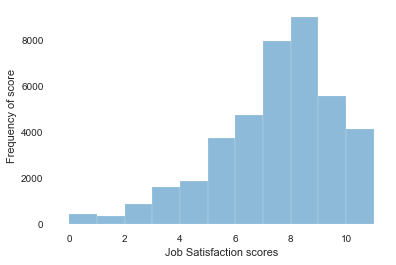

Year:  2018


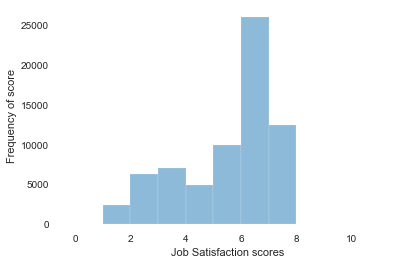

Year:  2019


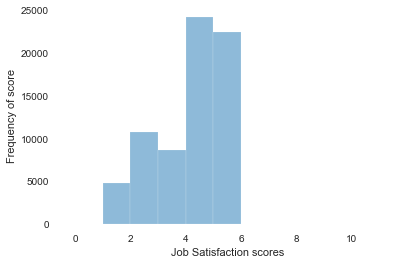

Year:  2020


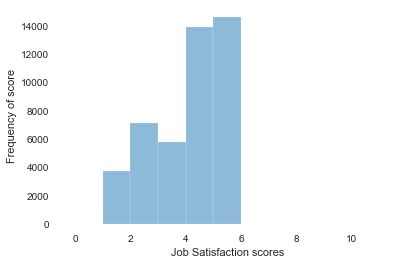

In [56]:
for year in years_df_dict_modified.keys():
    print('Year: ', year)
    df = years_df_dict_modified[year]
    df_srs = df['JobSat']
    bin_edges = range(0, 12)
    df_srs.plot.hist(bins=bin_edges, alpha=0.5)
    plt.xlabel('Job Satisfaction scores')
    plt.ylabel('Frequency of score')
    plt.show()

### yearly job satisfaction scores by country

In [57]:
def get_dict_of_dict_job_satisfaction(job_sat_scores_in):
    dict_data_dict = dict()
    dict_data_dict['Satisfied'] = job_sat_scores_in.get_high_scores()
    dict_data_dict['Neither'] =job_sat_scores_in.get_medium_scores()
    dict_data_dict['Dissatisfied'] = job_sat_scores_in.get_low_scores()
    dict_data_dict['Blank'] = job_sat_scores_in.get_blank_response()
    return dict_data_dict

In [58]:
def create_vincent_job_sat_bar_chart(df_in, countries_with_locations_srs, file_name_addendum, response_type_str):
    """
        manages the creation of grouped bar charts for job satisfaction scores

        Parameters
        ----------
           
                
        Returns
        -------
        bar
    """
    json_files_list = list()
    for country in countries_with_locations_srs.values:
        job_sat_scores_loc = countriesDataManager.get_job_sat_scores(country, response_type_str)
        
        dict_data_dict = get_dict_of_dict_job_satisfaction(job_sat_scores_loc)
        bar = plot_vincent_grouped_bar(dict_data_dict, 
                                       'Job Satisfaction', 
                                       'Percentage Score', 
                                       220, 
                                       250)
        
        json_file = country + '_'+ file_name_addendum + '.json'
        bar.to_json(json_file)
        json_files_list.append(json_file)
    df_copy = df_in.copy()
    df_copy['json_file'] = json_files_list
    return df_copy

In [59]:
locations_df_modified_job_sat =create_vincent_job_sat_bar_chart(locations_df, 
                                                                countries_with_locations, 
                                                                'job_sat', 
                                                                'JobSat')

In [60]:
popup_max_width = 500
global_job_sat_map = plot_map(locations_df_modified_job_sat, popup_max_width)

In [61]:
global_job_sat_map

In [62]:
#save_map_as_image(global_job_sat_map, 'global_job_sat_map')

### show yearly job satisfaction scores for selected countries

In [63]:
job_sat_scores_sweden = countriesDataManager.get_job_sat_scores('Sweden', 'JobSat')

In [64]:
dict_dict_sweden = get_dict_of_dict_job_satisfaction(job_sat_scores_sweden)

In [65]:
job_sat_bar_sweden = plot_vincent_grouped_bar(dict_dict_sweden, 
                                              'Job Satisfaction', 
                                              'Percentage Score', 
                                              220, 
                                              250)

In [66]:
job_sat_bar_sweden.display()

In [67]:
job_sat_scores_japan = countriesDataManager.get_job_sat_scores('Japan', 'JobSat')

In [68]:
dict_dict_japan = get_dict_of_dict_job_satisfaction(job_sat_scores_japan)

In [69]:
job_sat_bar_japan = plot_vincent_grouped_bar(dict_dict_japan, 
                                              'Job Satisfaction', 
                                              'Percentage Score', 
                                              220, 
                                              250)

In [70]:
job_sat_bar_japan.display()

## Top three programming languages overall

In [71]:
def get_rankings_df(top_n_yearly_ranking):
    """
        creates a pandas dataframe of yearly language rankings for countries

        Parameters
        ----------
           dict_of_data_dict : dictionary of dictionaries
                
        Returns
        -------
        bar
    """
    langauages_dat_list = []
    index_list = []
    for language in top_n_yearly_ranking.get_first_sorted_n_rankings_by_languages().keys():
        year_rankings_data = top_n_yearly_ranking[language]
        langauages_dat_list.append(year_rankings_data)
        index_list.append(language)
    lang_ranking_df = pd.DataFrame(langauages_dat_list, index=index_list)
    return lang_ranking_df

In [72]:
languageRanking = LanguageRanking()

In [73]:
for year in years_df_dict_modified.keys():
    df = years_df_dict_modified[year]
    languageRanking.set_rankings(df, year)

top_3_yearly_dict = languageRanking.get_first_sorted_n_rankings_by_languages()

In [74]:
top_3_yearly_bar = plot_vincent_grouped_bar(top_3_yearly_dict, 
                                            'Top Languages', 
                                            'Percentage Scores', 
                                            380, 
                                            250)

In [75]:
top_3_yearly_bar.display()

### yearly top three programming languages by country

In [76]:
def create_vincent_language_rankings_bar_chart(df_in, countries_with_locations_srs, file_name_addendum, response_type_str):
    """
        manages the creation of grouped bar charts for language rankings

        Parameters
        ----------
          
                
        Returns
        -------
        bar
    """
    json_files_list = list()
    for country in countries_with_locations_srs.values:
        languageYearlyRankings_loc = countriesDataManager.get_yearly_language_rankings(country, response_type_str)
        
        top_3_yearly_dict_loc = languageYearlyRankings_loc.get_first_sorted_n_rankings_by_languages()
        top_3_yearly_bar_loc = plot_vincent_grouped_bar(top_3_yearly_dict_loc, 
                                                        'Top Languages', 
                                                        'Percentage Scores', 
                                                        380, 
                                                        250)
        
        json_file = country + '_'+ file_name_addendum + '.json'
        top_3_yearly_bar_loc.to_json(json_file)
        json_files_list.append(json_file)  
    df_copy = df_in.copy()
    df_copy['json_file'] = json_files_list
    return df_copy

In [77]:
locations_df_modified_lang_ranking = create_vincent_language_rankings_bar_chart(locations_df, 
                                                                                countries_with_locations, 
                                                                                'lang_ranking', 
                                                                                'lang_ranking')

In [78]:
popup_max_width = 500
child_width=500
global_lang_ranking_map = plot_map(locations_df_modified_lang_ranking, popup_max_width, child_width)

In [79]:
global_lang_ranking_map

In [80]:
#save_map_as_image(global_lang_ranking_map, 'global_lang_ranking_map')

### show top three programming languages for selected countries

In [81]:
languageYearlyRankings = countriesDataManager.get_yearly_language_rankings('Sweden', 'lang_ranking')

In [ ]:
top_3_yearly_dict_sweden = languageYearlyRankings.get_first_sorted_n_rankings_by_languages()

In [ ]:
top_3_yearly_bar_sweden = plot_vincent_grouped_bar(top_3_yearly_dict_sweden, 
                                                   'Top Languages', 
                                                   'Percentage Scores', 
                                                   380, 
                                                   250)

In [ ]:
top_3_yearly_bar_sweden.display()

In [ ]:
languageYearlyRankings_usa = countriesDataManager.get_yearly_language_rankings('United States', 'lang_ranking')

In [ ]:
top_3_yearly_dict_usa = languageYearlyRankings_usa.get_first_sorted_n_rankings_by_languages()

In [ ]:
top_3_yearly_bar_usa = plot_vincent_grouped_bar(top_3_yearly_dict_usa, 
                                                'Top Languages', 
                                                'Percentage Scores', 
                                                380, 
                                                250)

In [ ]:
top_3_yearly_bar_usa.display()